<a href="https://colab.research.google.com/github/Jubayer934/Pneumonia-Detection-by-Symptoms-X-ray-Report/blob/main/pneumonia_tabuluer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ==============================
# PNEUMONIA DIAGNOSIS MODEL - Google Colab
# ==============================

In [ ]:
# Step 1: Install packages (quiet mode)
!pip install -q pandas scikit-learn imbalanced-learn ipywidgets joblib

# Step 2: Imports
import pandas as pd
import numpy as np
import joblib
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.5 MB/s eta 0:00:00


In [ ]:
# Step 3: Upload the CSV file (Run this cell and upload pneumonia_dataset.csv)
from google.colab import drive
drive.mount('/content/drive')


# Load data
df = pd.read_csv("/content/drive/MyDrive/ModelTrain/Pneumonia/dataset/pneumonia_dataset.csv")

Mounted at /content/drive


In [ ]:
print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} columns")
display(df.head())

Dataset loaded: 710 rows, 16 columns


,PatientID,Gender,Age,Cough,Fever,Shortness_of_breath,Chest_pain,Fatigue,Confusion,Oxygen_saturation,Crackles,Xray,WBC_count,Sputum_color,Temperature,Diagnosis
0,PNEU4091,M,3,Bloody,High,Mild,Mild,NaN,No,92,Yes,-,-,-,39.7,Yes
1,PNEU6231,M,3,Dry,NaN,NaN,NaN,Mild,-,-,Yes,-,-,Clear,37.0,No
2,PNEU6486,M,3,Dry,NaN,NaN,NaN,Mild,No,99,No,-,-,-,38.0,No
3,PNEU7601,F,3,NaN,Low,Severe,NaN,Moderate,No,99,Yes,-,-,Clear,40.9,Yes
4,PNEU8471,F,3,NaN,High,Moderate,Severe,Mild,-,91,No,-,-,Green,38.1,Yes


# ==============================
# PREPROCESSING
# ==============================

In [ ]:
# Drop irrelevant columns (PatientID, Xray, WBC_count - high missing)
cols_to_drop = ['PatientID', 'Xray', 'WBC_count']
df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])

# Replace missing markers: '-', 'None', empty → NaN
df.replace(['-', 'None', ''], np.nan, inplace=True)

In [ ]:
# Define columns
categorical_cols = ['Gender', 'Cough', 'Fever', 'Shortness_of_breath',
                    'Chest_pain', 'Fatigue', 'Confusion', 'Crackles', 'Sputum_color']
numerical_cols = ['Age', 'Oxygen_saturation', 'Temperature']

In [ ]:
# Fill missing values (same as training logic)
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].fillna('Unknown')

In [ ]:
# Numerical: convert & fill with median
for col in numerical_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        df[col] = df[col].fillna(df[col].median())

In [ ]:
df.head()

,Gender,Age,Cough,Fever,Shortness_of_breath,Chest_pain,Fatigue,Confusion,Oxygen_saturation,Crackles,Sputum_color,Temperature,Diagnosis
0,M,3,Bloody,High,Mild,Mild,Unknown,No,92.0,Yes,Unknown,39.7,Yes
1,M,3,Dry,Unknown,Unknown,Unknown,Mild,Unknown,93.0,Yes,Clear,37.0,No
2,M,3,Dry,Unknown,Unknown,Unknown,Mild,No,99.0,No,Unknown,38.0,No
3,F,3,Unknown,Low,Severe,Unknown,Moderate,No,99.0,Yes,Clear,40.9,Yes
4,F,3,Unknown,High,Moderate,Severe,Mild,Unknown,91.0,No,Green,38.1,Yes


In [ ]:
# Target: Yes=1, No=0
y = df['Diagnosis'].map({'Yes': 1, 'No': 0})
X = df.drop('Diagnosis', axis=1)

In [ ]:
y

,Diagnosis
0,1
1,0
2,0
3,1
4,1
...,...
705,1
706,1
707,0
708,1


In [ ]:
X

,Gender,Age,Cough,Fever,Shortness_of_breath,Chest_pain,Fatigue,Confusion,Oxygen_saturation,Crackles,Sputum_color,Temperature
0,M,3,Bloody,High,Mild,Mild,Unknown,No,92.0,Yes,Unknown,39.7
1,M,3,Dry,Unknown,Unknown,Unknown,Mild,Unknown,93.0,Yes,Clear,37.0
2,M,3,Dry,Unknown,Unknown,Unknown,Mild,No,99.0,No,Unknown,38.0
3,F,3,Unknown,Low,Severe,Unknown,Moderate,No,99.0,Yes,Clear,40.9
4,F,3,Unknown,High,Moderate,Severe,Mild,Unknown,91.0,No,Green,38.1
...,...,...,...,...,...,...,...,...,...,...,...,...
705,F,90,Wet,Unknown,Moderate,Moderate,Moderate,No,99.0,Yes,Green,38.3
706,F,90,Dry,High,Moderate,Moderate,Moderate,Yes,91.0,Yes,Bloody,37.2
707,M,90,Dry,Unknown,Unknown,Unknown,Mild,No,90.0,Yes,Unknown,37.0
708,M,90,Unknown,Moderate,Severe,Severe,Moderate,No,93.0,Yes,Bloody,36.2


In [ ]:
print(f"\nTarget distribution (before balancing):")
print(y.value_counts(normalize=True).apply(lambda x: f"{x:.1%}"))


Target distribution (before balancing):
Diagnosis
1    57.5%
0    42.5%
Name: proportion, dtype: object


In [ ]:
# One-hot encode categorical
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
cat_encoder.fit(X[categorical_cols])
X_cat = pd.DataFrame(cat_encoder.transform(X[categorical_cols]),
                     columns=cat_encoder.get_feature_names_out(), index=X.index)

# Scale numerical
scaler = StandardScaler()
X_num = pd.DataFrame(scaler.fit_transform(X[numerical_cols]), columns=numerical_cols, index=X.index)

In [ ]:
# Combine
X_processed = pd.concat([X_num, X_cat], axis=1)

In [ ]:
# Train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X_processed, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
print(f"\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

In [ ]:
# Balance training set
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

# Train SVM
model = SVC(C=10, kernel='rbf', probability=True, random_state=42)
model.fit(X_train_bal, y_train_bal)

print("Model trained!")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, X, y, name="Test"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, y_pred)

    print(f"\n📊 {name} Set Evaluation")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y, y_pred, target_names=['Non_Pneumonia', 'Pneumonia']))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non_Pneumonia', 'Pneumonia'], yticklabels=['Non_Pneumonia', 'Pneumonia'])
    plt.title(f'{name} Set Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

In [ ]:
val_metrics = evaluate(model, X_val, y_val, "Validation Set")

In [ ]:
test_metrics = evaluate(model, X_test, y_test, "Test Set")

In [ ]:
import os
save_path = '/content/drive/MyDrive/ModelTrain/Pneumonia/model/pneumonia_model.pkl'


# Save full prediction system
prediction_system = {
    'model': model,
    'cat_encoder': cat_encoder,
    'num_cols': numerical_cols,
    'cat_cols': categorical_cols,
    'scaler': StandardScaler().fit(X_train[numerical_cols])  # Fit scaler on train
}

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

joblib.dump(prediction_system, save_path)
print("\nModel saved as 'pneumonia_model.pkl'")

In [ ]:
# Load the saved prediction system
import joblib
save_path = '/content/drive/MyDrive/ModelTrain/Pneumonia/model/pneumonia_model.pkl'
prediction_system = joblib.load(save_path)

print("Prediction system loaded successfully.")

# ==============================
# PIPELINE SETUP
# ==============================

In [ ]:
# One-hot encode categorical
cat_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')
X_cat_encoded = pd.DataFrame(
    cat_encoder.fit_transform(X[categorical_cols]),
    columns=cat_encoder.get_feature_names_out(categorical_cols),
    index=X.index
)

# Scale numerical
scaler = StandardScaler()
X_num_scaled = pd.DataFrame(
    scaler.fit_transform(X[numerical_cols]),
    columns=numerical_cols,
    index=X.index
)

In [ ]:
# Combine processed features
X_processed = pd.concat([X_num_scaled, X_cat_encoded], axis=1)
print(f"Processed features: {X_processed.shape[1]} total")

Processed features: 26 total


In [ ]:
print("\nProcessed features (columns):")
print(X_processed.columns.tolist())


Processed features (columns):
['Age', 'Oxygen_saturation', 'Temperature', 'Gender_M', 'Cough_Dry', 'Cough_Unknown', 'Cough_Wet', 'Fever_Low', 'Fever_Moderate', 'Fever_Unknown', 'Shortness_of_breath_Moderate', 'Shortness_of_breath_Severe', 'Shortness_of_breath_Unknown', 'Chest_pain_Moderate', 'Chest_pain_Severe', 'Chest_pain_Unknown', 'Fatigue_Moderate', 'Fatigue_Severe', 'Fatigue_Unknown', 'Confusion_Unknown', 'Confusion_Yes', 'Crackles_Yes', 'Sputum_color_Clear', 'Sputum_color_Green', 'Sputum_color_Unknown', 'Sputum_color_Yellow']


# ==============================
# Step 5: SPLIT DATA (70/15/15, stratified)
# ==============================

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_processed, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, stratify=y_train_val, random_state=42  # 15/(70+15)
)

In [ ]:
print(f"\nSplits: Train={X_train.shape[0]}, Val={X_val.shape[0]}, Test={X_test.shape[0]}")


Splits: Train=496, Val=107, Test=107


# ==============================
# TRAIN MODEL
# ==============================

In [ ]:
# Balance training set
smote = SMOTE(random_state=42)
X_train_val, y_train_val = smote.fit_resample(X_train, y_train)
print(f"After SMOTE: {y_train_val.value_counts(normalize=True).iloc[0]:.1%} (balanced)")

# Train SVM
svm_model = SVC(C=10, kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_val, y_train_val)
print("✅ Model trained!")

After SMOTE: 50.0% (balanced)
✅ Model trained!


# ==============================
# EVALUATION
# ==============================

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate(model, X, y, name="Test"):
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]
    acc = accuracy_score(y, y_pred)

    print(f"\n📊 {name} Set Evaluation")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y, y_pred, target_names=['Non_Pneumonia', 'Pneumonia']))

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Non_Pneumonia', 'Pneumonia'], yticklabels=['Non_Pneumonia', 'Pneumonia'])
    plt.title(f'{name} Set Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


📊 Validation Set Set Evaluation
Accuracy: 0.9813
               precision    recall  f1-score   support

Non_Pneumonia       0.96      1.00      0.98        45
    Pneumonia       1.00      0.97      0.98        62

     accuracy                           0.98       107
    macro avg       0.98      0.98      0.98       107
 weighted avg       0.98      0.98      0.98       107



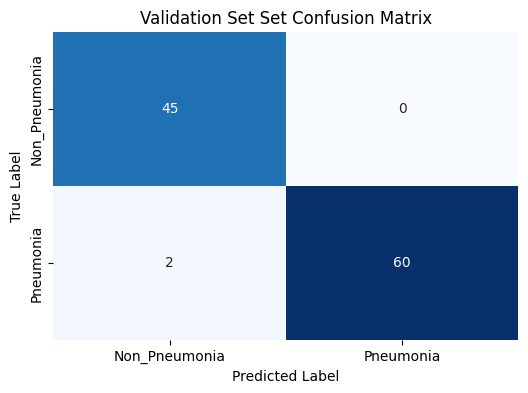

In [ ]:
val_metrics = evaluate(svm_model, X_val, y_val, "Validation Set")


📊 Test Set Set Evaluation
Accuracy: 0.9720
               precision    recall  f1-score   support

Non_Pneumonia       0.94      1.00      0.97        46
    Pneumonia       1.00      0.95      0.97        61

     accuracy                           0.97       107
    macro avg       0.97      0.98      0.97       107
 weighted avg       0.97      0.97      0.97       107



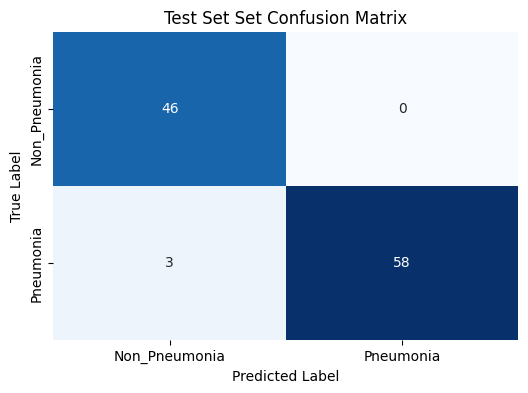

In [ ]:
test_metrics = evaluate(svm_model, X_test, y_test, "Test Set")

# ==============================
# SAVE MODEL & ARTIFACTS
# ==============================

In [ ]:
import os
save_path = '/content/drive/MyDrive/ModelTrain/Pneumonia/model/pneumonia_tabuluer_model.pkl'
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

prediction_system = {
    'model': svm_model,
    'cat_encoder': cat_encoder,
    'scaler': scaler,
    'cat_cols': categorical_cols,
    'num_cols': numerical_cols,
    'feature_names': X_processed.columns.tolist()  # For verification
}
joblib.dump(prediction_system, save_path)
print("\n💾 Model saved as 'pneumonia_tabuluer_model.pkl'")



💾 Model saved as 'pneumonia_model.pkl'


# ==============================
# PREDICTION FUNCTION
# ==============================

In [ ]:
# Load the saved prediction system
import joblib
save_path = '/content/drive/MyDrive/ModelTrain/Pneumonia/model/pneumonia_tabuluer_model.pkl'
prediction_system = joblib.load(save_path)

print("Prediction system loaded successfully.")

Prediction system loaded successfully.


In [ ]:
def safe_predict(patient_dict):
    # Load system
    system = joblib.load('/content/drive/MyDrive/ModelTrain/Pneumonia/model/pneumonia_tabuluer_model.pkl') # Corrected path
    model = system['model']
    cat_encoder = system['cat_encoder']
    scaler = system['scaler']
    cat_cols = system['cat_cols']
    num_cols = system['num_cols']

    # DataFrame
    df_in = pd.DataFrame([patient_dict])

    # Handle missing: replace markers → NaN
    df_in.replace(['', '-', 'None', None], np.nan, inplace=True)

    # Categorical → 'Unknown'
    for col in cat_cols:
        df_in[col] = df_in[col].fillna('Unknown')

    # Numerical → training medians (from scaler.mean_)
    scaler_means = dict(zip(num_cols, scaler.mean_))
    for col in num_cols:
        df_in[col] = pd.to_numeric(df_in[col], errors='coerce')
        df_in[col] = df_in[col].fillna(scaler_means.get(col, 0))

    # Encode categorical
    cat_encoded = pd.DataFrame(
        cat_encoder.transform(df_in[cat_cols]),
        columns=cat_encoder.get_feature_names_out(cat_cols), # Added cat_cols for clarity
        index=df_in.index
    )

    # Scale numerical
    num_scaled = pd.DataFrame(
        scaler.transform(df_in[num_cols]),
        columns=num_cols,
        index=df_in.index
    )

    # Combine (match training order)
    X_final = pd.concat([num_scaled, cat_encoded], axis=1)
    X_final = X_final.reindex(columns=system['feature_names'], fill_value=0)

    # Predict
    prob = model.predict_proba(X_final)[0]
    pred = model.predict(X_final)[0]
    confidence = prob[pred] * 100
    result = "Pneumonia" if pred == 1 else "No Pneumonia"

    return result, confidence

# ==============================
# Step 11: INTERACTIVE WIDGET (Test predictions)
# ==============================
print("\n🎯 Interactive Prediction Tool")
print("Leave fields blank or enter '-' for missing → auto-handled!")

style = {'description_width': 'initial'}
layout = widgets.Layout(width='500px')

inputs = {
    'Gender': widgets.Dropdown(options=['M', 'F'], value='M', description='Gender:', style=style, layout=layout),
    'Age': widgets.Text(placeholder='e.g. 65', description='Age:', style=style, layout=layout),
    'Cough': widgets.Dropdown(options=['Bloody', 'Dry', 'Wet', 'None', 'Unknown'], description='Cough:', style=style, layout=layout),
    'Fever': widgets.Dropdown(options=['High', 'Low', 'Moderate', 'None', 'Unknown'], description='Fever:', style=style, layout=layout),
    'Shortness_of_breath': widgets.Dropdown(options=['Severe', 'Moderate', 'Mild', 'None', 'Unknown'], description='Shortness of Breath:', style=style, layout=layout),
    'Chest_pain': widgets.Dropdown(options=['Severe', 'Moderate', 'Mild', 'None', 'Unknown'], description='Chest Pain:', style=style, layout=layout),
    'Fatigue': widgets.Dropdown(options=['Severe', 'Moderate', 'Mild', 'None', 'Unknown'], description='Fatigue:', style=style, layout=layout),
    'Confusion': widgets.Dropdown(options=['Yes', 'No', 'Unknown'], description='Confusion:', style=style, layout=layout),
    'Oxygen_saturation': widgets.Text(placeholder='e.g. 92', description='O2 Sat (%):', style=style, layout=layout),
    'Crackles': widgets.Dropdown(options=['Yes', 'No'], value='No', description='Crackles:', style=style, layout=layout),
    'Sputum_color': widgets.Dropdown(options=['Bloody', 'Green', 'Yellow', 'Clear', 'Unknown'], description='Sputum Color:', style=style, layout=layout),
    'Temperature': widgets.Text(placeholder='e.g. 39.5', description='Temp (°C):', style=style, layout=layout),
}

output = widgets.Output()
button = widgets.Button(description="🔮 Predict", button_style='primary', layout=widgets.Layout(width='200px'))

def on_click(b):
    with output:
        clear_output()
        data = {k: (v.value.strip() if isinstance(v, widgets.Text) else v.value) for k, v in inputs.items()}
        # Empty text → None (for missing handling)
        for k in ['Age', 'Oxygen_saturation', 'Temperature']:
            if not data[k]:
                data[k] = None
        result, conf = safe_predict(data) # Corrected function call
        print(f"**Prediction:** {result}")
        print(f"**Confidence:** {conf:.2f}%")

button.on_click(on_click)

# Display form
title = HTML("<h3 style='text-align:center;'>Enter Patient Data & Predict</h3>")
display(title) # Display title separately
form = widgets.VBox(list(inputs.values()) + [button, output]) # Removed title from VBox children
display(form)


🎯 Interactive Prediction Tool
Leave fields blank or enter '-' for missing → auto-handled!
